In [1]:
import numpy as np
import pandas as pd
import datetime
import torch.optim as optim
from scipy import io
import argparse
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py  
import matplotlib.pyplot as plt
import matplotlib
# print(matplotlib.__version__)
# matplotlib.use('Agg')
import h5py  

from PIL import Image
import math
from sklearn.metrics import confusion_matrix
import pylab as pl
import numpy as np
import itertools
import torchvision

In [2]:
matrix_size = int(218)

pf_line = int(np.floor(matrix_size*0.45))
pf_line_com = matrix_size-pf_line
pf_line_o =int(np.floor(170*0.45)) 
SS_flag =0
MS_flag =0
EMS_flag =1

In [3]:
data_file = 'C:/Users/Asus/Documents/DL-Partial_fourier/calgary_multicoil/e15598s3_P54784.7.h5'


In [4]:
with h5py.File(data_file, 'r') as f: 
    kspace = f['kspace']
    

    kspace = np.transpose(kspace,(0, 2, 1, 3))
    kspace_shape = kspace.shape;
    
    imaginary = kspace[:,:,:,0:12];    # Right now, I'm unsure about what is real and imaginary but currently this works.
    real = kspace[:,:,:,12:24];
    
    data = real + imaginary*1j;
    
    
    

In [5]:
print(data.shape)


(256, 170, 218, 12)


In [6]:
sz = data.shape
freq= np.fft.ifftshift(data ,axes=0)
freq = np.fft.ifft(freq,axis =0)

In [7]:
data1 = np.sqrt(sz[0])*np.fft.fftshift(freq,axes=0)
# data1 = np.sqrt(sz[0])*freq

In [8]:
# plt.imshow(np.log(np.squeeze(abs(data[:,:, 20, 6]))-1e-10), cmap='gray')

In [9]:
print(data1.shape)

(256, 170, 218, 12)


In [10]:
data2 = np.reshape(data1,(-1,1,sz[1],sz[2])) # change sz[2] and sz[3]

In [11]:
print(data2.shape)

(3072, 1, 170, 218)


In [12]:
# plt.imshow(np.log(abs(data2[150,0, :, :])-1e-10), cmap='gray')

In [13]:
freq= np.fft.ifftshift(data2 ,axes=(2,3))
freq = np.fft.ifft2(freq,axes=(2,3))
img = np.sqrt(sz[1]*sz[2])*np.fft.fftshift(freq,axes=(2,3)) # change sz[1] sz[2]

In [14]:
scale_ref = round(np.max(np.absolute(img)),15)
img = img/scale_ref

In [15]:
print(img.shape)

(3072, 1, 170, 218)


In [16]:
# plt.imshow((abs(img[91,0, :, :])), cmap='gray')

In [17]:
##single slice
if SS_flag ==1:
    img_ref  = img[1:sz[0]-1,:,:,:]*0
    for k in range(1,sz[0]-1):
        img_ref[k-1,:,:,:] = img[k,:,:,:]
else:
    img_ref = np.concatenate((img[1:sz[0]-1,:,:,:]*0,img[1:sz[0]-1,:,:,:]*0,img[1:sz[0]-1,:,:,:]*0),axis = 1)
    for k in range(1,sz[0]-1):
        img_ref[k-1,:,:,:] = np.concatenate((img[k,:,:,:],  img[k-1,:,:,:], img[k+1,:,:,:]), axis =0)

In [18]:
print(img_ref.shape)

(254, 3, 170, 218)


In [19]:
##multi slice
freq= np.fft.ifftshift(img_ref ,axes=(2,3))
freq= np.fft.fft2(freq ,axes=(2,3))
test_k= 1/np.sqrt(sz[1]*sz[2])*np.fft.fftshift(freq,axes=(2,3))   
test_data = np.copy(test_k)
test_data[:,0,:,:pf_line] = 0

In [20]:
##############complementry sampling pattern
if EMS_flag ==1:
    test_data[:,1:3,:,pf_line_com:] = 0

if MS_flag==1:
    test_data[:,1:3,:,:pf_line] = 0

In [21]:
print(test_data.shape)

(254, 3, 170, 218)


In [22]:
freq = np.fft.ifftshift(test_data,axes=(2,3))
freq = np.fft.ifft2(freq ,axes=(2,3))
img_data = np.sqrt(sz[2]*sz[3])*np.fft.fftshift(freq,axes=(2,3))

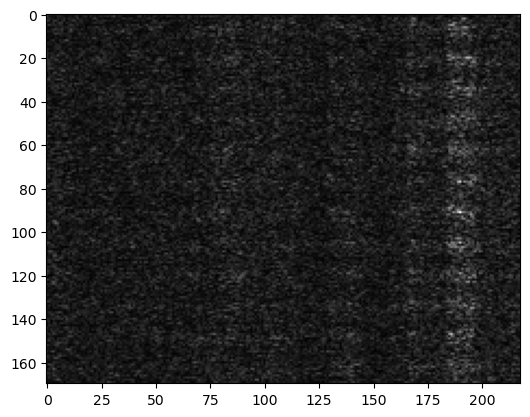

In [23]:
# plt.imshow((abs(img_data[90,0, :, :])), cmap='gray')

In [24]:
img_label =img_ref[:,0,:,:] -img_data[:,0,:,:]
img_label =img_label.reshape(sz[0]-2,-1,sz[1],sz[2])

imgdataR = np.copy(np.real(img_data))
imgdataI = np.copy(np.imag(img_data))

imgdata = np.concatenate((imgdataR,imgdataI), axis=1)



imglabelR = np.copy(np.real(img_label))
imglabelI = np.copy(np.imag(img_label))
imglabel = np.concatenate((imglabelR,imglabelI), axis=1)


imgfull=img_label[:,0,:,:] + img_data[:,0,:,:]
imgfull =imgfull.reshape(sz[0]-2,-1,sz[1],sz[2])


In [25]:
imgdata.shape

(254, 6, 170, 218)

In [26]:
imglabel.shape

(254, 2, 170, 218)

In [27]:
# k_nor = np.fft.ifftshift(imgfull,axes=(2,3))  
# k_nor= np.fft.fft2(k_nor ,axes=(2,3))
# k_nor = 1/np.sqrt(sz[1]*sz[2])*np.fft.fftshift(k_nor,axes=(2,3))  

# k_zero = np.fft.ifftshift(img_data,axes=(2,3))  
# k_zero= np.fft.fft2(k_zero ,axes=(2,3)) 

# k_zero = 1/np.sqrt(sz[1]*sz[2])*np.fft.fftshift(k_zero,axes=(2,3))

# k_label = np.fft.ifftshift(img_label,axes=(2,3))  
# k_label= np.fft.fft2(k_label ,axes=(2,3))
# k_label = 1/np.sqrt(sz[1]*sz[2])*np.fft.fftshift(k_label,axes=(2,3))  

In [28]:
for i in range(16,int(sz[0]-20)):
    D = torch.from_numpy(imgdata[i,:,:,:]).float()
    L = torch.from_numpy(imglabel[i,:,:,:]).float()
    data = {'k-space':D,'label':L}
#         torch.save(data,current_file_data_save +'/train/'+str(idx)+'_'+str(i)+'.pth')
f.close()

In [29]:
# data['k-space']

In [ ]:
## Code below test model2_cpx.py file segment

In [30]:
first_16_D = []

for i in range(16, min(16 + 16, sz[0] - 20)):  # Adjusted loop range to ensure we don't exceed image size
    D = torch.from_numpy(imgdata[i, :, :, :]).float()
    first_16_D.append(D)  # Add the tensor to the list with an added dimension

first_16_D = torch.stack(first_16_D)  # Convert the list of tensors into a single tensor


In [31]:
x = first_16_D

In [32]:
x.shape

torch.Size([16, 6, 170, 218])

In [36]:
or_im = x
nsize = x.size()
pf_1 = math.floor(nsize[3] * 0.40)
pf_com_1 = nsize[3] - pf_1
pf_0 = math.floor(nsize[2] * 0.40)
pf_com_0 = nsize[2] - pf_0



In [37]:
or_k = torch.complex(or_im[:, 0, :, :], or_im[:, 1, :, :])


In [39]:
or_k = torch.fft.ifftshift(or_k, dim=(1, 2))
or_k = torch.fft.fft2(or_k, dim=(1, 2))
or_k = 1 / math.sqrt(nsize[2] * nsize[3]) * torch.fft.fftshift(or_k, dim=(1, 2))

In [40]:


y = x
for i in range(3):
    x = y
    new_k = torch.complex(x[:, 0, :, :], x[:, 1, :, :])
    new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
    new_k = torch.fft.fft2(new_k, dim=(1, 2))
    new_k = 1 / math.sqrt(nsize[2] * nsize[3]) * torch.fft.fftshift(new_k, dim=(1, 2))
    

    
    new_k[:, :pf_0, :] = or_k[:, :pf_0, :]
    new_k[:, :, :pf_1] = or_k[:, :, :pf_1]
    
    new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
    new_k = torch.fft.ifft2(new_k, dim=(1, 2))
    new_k = math.sqrt(nsize[2] * nsize[3]) * torch.fft.fftshift(new_k, dim=(1, 2))
    
    print(new_k.shape)
    new_k = torch.stack((torch.real(new_k), torch.imag(new_k)), dim=1)
    print(new_k.shape)
    
#     x = x + self.t * (new_k - or_im)

#     res = self.head(x)
#     res = self.body(res)
#     y = self.tail(res) + x



torch.Size([16, 170, 218])
torch.Size([16, 2, 170, 218])
torch.Size([16, 170, 218])
torch.Size([16, 2, 170, 218])
torch.Size([16, 170, 218])
torch.Size([16, 2, 170, 218])


In [ ]:
or_k.shape

In [ ]:
new_k = torch.complex(y[:, 0, :, :], y[:, 1, :, :])
new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
new_k = torch.fft.fft2(new_k, dim=(1, 2))
new_k = 1 / math.sqrt(nsize[2] * nsize[3]) * torch.fft.fftshift(new_k, dim=(1, 2))
new_k_ = or_k
new_k_[:, :pf_0, :] = new_k[:, :pf_0, :]
new_k_[:, :, :pf_1] = new_k[:, :, :pf_1]
new_k = new_k_
new_k = torch.fft.ifftshift(new_k, dim=(1, 2))
new_k = torch.fft.ifft2(new_k, dim=(1, 2))
new_k = math.sqrt(nsize[2] * nsize[3]) * torch.fft.fftshift(new_k, dim=(1, 2))
y = torch.stack((torch.real(new_k), torch.imag(new_k)), dim=1)